# Sentiment analysis on r/wallstreetbets in reddit
    - obtain data using reddit api
    - scrub data by storing it in pandas dataframe
    - histogram to see overall scores of post
    - wordcloud
    - calculate sentiment score of each post
    - search engine (we take one keyword from wordcloud and search in review database (to get the review complete story)

# Obtain

- obtain data using reddit api


In [28]:
# reference : https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import os
from dotenv import load_dotenv

load_dotenv()


# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(
    os.getenv('reddit_personal_use_script'), os.getenv('reddit_api_secret')
)

# here we pass our login method (password), username, and password
data = {
    "grant_type": "password",
    "username": os.getenv('reddit_username'),
    "password": os.getenv('reddit_pass'),
}

# setup our header info, which gives reddit a brief description of our app
headers = {"User-agent": "sentiment-score/0.0.1"}

# send our request for an OAuth token
res = requests.post(
    "https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=headers
)

# convert response to JSON and pull access_token value
TOKEN = res.json()["access_token"]

# add authorization to our headers dictionary
headers = {**headers, **{"Authorization": f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get("https://oauth.reddit.com/api/v1/me", headers=headers)

print(res.json()['expires_in'])

# output 3600 represents we have 3600 minutes on using this access_token in `res.json()['access_token']`

3600


In [29]:
# commented bc this output is raw (takes up space, below show tidier way putting it inside pandas dataframe)

# # get hot subreddit in r/wallstreetbets

# res = requests.get("https://oauth.reddit.com/r/wallstreetbets/hot",headers=headers)

# print(res.json())

# Scrub

- scrub data by storing it in pandas dataframe

In [30]:
# make a request for the trending posts in /r/wallstreetbets, but post it in pandas dataframe

res = requests.get("https://oauth.reddit.com/r/wallstreetbets/hot",
                   headers=headers)

df = pd.DataFrame()  # initialize dataframe

# loop through each post retrieved from GET request
for post in res.json()['data']['children']:
    # append relevant data to dataframe
    df = df.append({
        'subreddit': post['data']['subreddit'],
        'title': post['data']['title'],
        'selftext': post['data']['selftext'],
        'upvote_ratio': post['data']['upvote_ratio'],
        'ups': post['data']['ups'],
        'downs': post['data']['downs'],
        'score': post['data']['score']
    }, ignore_index=True)

In [31]:
df.head(3)

,subreddit,title,selftext,upvote_ratio,ups,downs,score
0,wallstreetbets,"Daily Discussion Thread for August 04, 2021",Your daily trading discussion thread. Please k...,0.89,192.0,0.0,192.0
1,wallstreetbets,"Daily Popular Tickers Thread for August 04, 20...",\nYour daily hype thread. Please keep the shit...,0.93,161.0,0.0,161.0
2,wallstreetbets,My experience trading with Robinhood this past...,,0.96,4630.0,0.0,4630.0


# Explore     

- histogram to see overall scores of post


In [32]:
# lets treat 'score' as 'rating' like in tripadvisor feedback
df = df[['title', 'score']]
df.head(3)

,title,score
0,"Daily Discussion Thread for August 04, 2021",192.0
1,"Daily Popular Tickers Thread for August 04, 20...",161.0
2,My experience trading with Robinhood this past...,4630.0


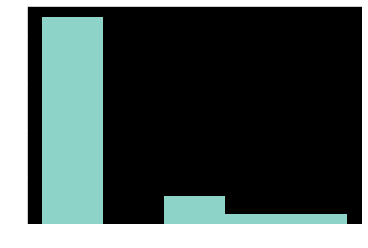

In [37]:
# plot histogram
plt.hist(df['score'], bins=5)
plt.show()

# Model

- wordcloud
- calculate sentiment score of each post
- search engine (we take one keyword from wordcloud and search in review database (to get the review complete story)

In [38]:
# wordcloud function

from wordcloud import WordCloud

# function to create wordcloud
def wordcloud_generator(data, title=None):
    ''' Input review/description/long text column from dataset, Output wordcloud '''

    # enter data into wordcloud & pre-set the size of plot
    wordcloud = WordCloud(
            width=800,
            height=800,
            background_color='black',
            min_font_size=10
        ).generate(" ".join(data.values))

    # set the plt 'canvas' and plot wordcloud on it
    plt.figure(figsize=(8,8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=30)
    plt.show()    

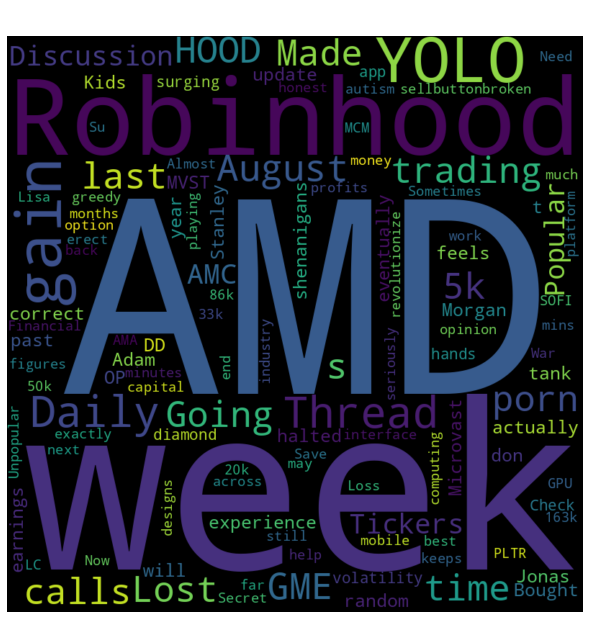

In [39]:
wordcloud_generator(df['title'], title="Most used word in r/wallstreetbets")

### Word we can look into :
- AMD, YOLO, GME


#### Sentiment score can be improved by scrub punctuation & stopwords (see scrub [here](https://github.com/dwihdyn/ds-exploration/blob/main/p3/d22-sentiment-analysis.ipynb))

In [40]:
# sentiment analysis packages
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# calculate sentiment value for all ratings, using polarity_scores
analyzer = SentimentIntensityAnalyzer()
sentiments = [analyzer.polarity_scores(i)['compound'] for i in df['title']]

# append result to main df
df['Sentiments'] = sentiments
df.sample(3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dwihadyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,title,score,Sentiments
25,AMD is going to revolutionize the GPU computin...,18.0,0.0000
24,Lisa Su keeps my autism erect $AMD,318.0,0.0000
20,Over 33k in AMD profits 🥳,538.0,0.4404


In [60]:
# search engine that input data, output review that is closest (vector location) to the query input by cosine_similarity

def search_engine(query, key_title_column, sentimentscore_column, description_column):
    '''Input search query & description column in the database, output top5 most relevant result as per search query towards descriptions'''
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    # scrub the data from any english stopwords
    tfidf = TfidfVectorizer(stop_words='english')

    # train TfidfVectorizer using movie description
    feature = tfidf.fit_transform(description_column)

    # insert the keyword that we want to search
    query = query

    # transform input into vector that shall be compared which the closest to the movie description
    query_feature = tfidf.transform([query])

    # compare query input to movie descriotion using cosine_similarity method
    cosims = cosine_similarity(query_feature, feature).flatten()

    # get the vector top5 closest to the query
    results = cosims.argsort()[-4 : -1]
        
    # show search result
    for i in results:
        print(key_title_column.iloc[i])
        print(sentimentscore_column.iloc[i])
        print(description_column.iloc[i])
        print('------')

# iNterpret

- show top3 :
    - least sentiment, but its high score
    - highest sentiment, but its low score
- interpret search engine output of different keyword

In [55]:
# show top3 least sentiment, but high score

pd.set_option('display.max_colwidth', None)
df[(df['score'] > 500) & (df['Sentiments'] < 0)].sort_values("Sentiments")[0:3]

,title,score,Sentiments
14,Loss porn - Need help seriously,1164.0,-0.0772


In [56]:
# show top3 highest sentiment, but low score

df[(df['score'] < 500) & (df['Sentiments'] > 0)].sort_values("Sentiments", ascending=False)[0:3]

,title,score,Sentiments
23,"1000% gain $225 option playing into 2.5k AMD, it may not be much but it’s honest work",20.0,0.7935
22,"Gain Porn! 2,466% with $LC last week. Now it’s time for $SOFI end of next week. Almost up 100% across calls!",25.0,0.6103
21,"PLTR YOLO , 🚀 or 💩",54.0,0.4278


In [61]:
search_engine('AMD', df['score'], df['Sentiments'], df['title'])

318.0
0.0
Lisa Su keeps my autism erect $AMD
------
325.0
0.34
86k in 1 week AMD gains (so far)
------
584.0
0.0
Bought some AMD calls last week before earnings.
------


In [62]:
search_engine('YOLO', df['score'], df['Sentiments'], df['title'])

20.0
-0.3182
Made about 1/3 of the money I lost on their platform back in 10 minutes
------
3226.0
0.4278
GME 20k YOLO - Going to 0 or 6 figures
------
262.0
0.2732
HOOD yolo update
------


In [63]:
search_engine('GME',  df['score'], df['Sentiments'], df['title'])

4630.0
0.0
My experience trading with Robinhood this past year
------
20.0
-0.3182
Made about 1/3 of the money I lost on their platform back in 10 minutes
------
161.0
0.4215
Daily Popular Tickers Thread for August 04, 2021 - AMD | GME | AMC
------


## Summary on finding :
    - not a financial advice
    - sentiment score works well on short sentences. it reflects the score & sentiment of the sentences pretty accurately (losing money is -ve sentiment score, and vise versa)
    - some users are still gaining profit on AMD stocks
    - some people YOLO (gamble) their money on recent robinhood IPO
    - GME is still trending despite it was hot topic months ago